**Reference**
- [NLP with Disaster Tweets - EDA, Cleaning and BERT](https://https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#0.-Introduction-and-References) by [GUNES EVITAN](https://www.kaggle.com/gunesevitan)
- [KerasNLP starter notebook Disaster Tweets](https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook) by [Alexia Audevart](https://www.kaggle.com/alexia) and others

In [1]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.0 MB/s eta 0:00:00


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import random
import time
import itertools
import spacy
import nltk
import ftfy
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ydata_profiling import ProfileReport
from geopy.geocoders import Nominatim

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# DistilBERT
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.callbacks import EarlyStopping

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
2024-06-12 00:27:18.745215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 00:27:18.745356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 00:27:18.931908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-disaster-preprocessed-combined-2/nlp_disaster_preprocessed_combined (1).json


In [4]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /usr/share/nltk_data...
[nltk_data]    | Downloading pa

True

In [5]:
# import files
orig_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
combined = pd.concat([orig_train, test], ignore_index=True)

# 0. Explore Data

In [6]:
ProfileReport(orig_train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
ProfileReport(test)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 1. Preprocessing

**Text Cleaning**

In [8]:
def text_cleaning(text):
    # remove urls
    ent = re.sub(r"(?:https|http|mailto|ftp|file):\/\/\S+\s?", "", text)
    
    # clean unicodes by ftfy
    ent = ftfy.fix_text(ent)
    
    # split punctuations from words
    puncs = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    for p in puncs:
        ent = ent.replace(p, f' {p} ')

    ent = ent.lower()
    
    # abbreviation
    abbreviation_mapping = {
    "i'm": "i am",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "it's": "it is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "can't": "cannot",
    "couldn't": "could not",
    "won't": "will not",
    "wouldn't": "would not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "i'd": "i would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "i'll": "i will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "i've": "i have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "who's": "who is",
    "what's": "what is",
    "where's": "where is",
    "when's": "when is",
    "why's": "why is",
    "how's": "how is",
    "let's": "let us",
    "that's": "that is",
    "there's": "there is",
    "here's": "here is",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "sha'n't": "shall not",
    "shan't": "shall not",
    "ain't": "is not",
    "daren't": "dare not",
    "ma'am": "madam",
    "o'clock": "of the clock",
    "y'all": "you all",
    "gonna": "going to",
    "wanna": "want to",
    "gotta": "got to",
    "kinda": "kind of",
    "sorta": "sort of",
    "lotta": "lot of",
    "lemme": "let me",
    "gimme": "give me",
    "innit": "is it not",
    "betcha": "bet you",
    "c'mon": "come on",
    "y'know": "you know",
    "whatcha": "what are you",
    "d'you": "do you",
    "could've": "could have",
    "should've": "should have",
    "would've": "would have",
    "might've": "might have",
    "must've": "must have",
    "how'd": "how did",
    "how'll": "how will",
    "when'd": "when did",
    "where'd": "where did",
    "who'd": "who would",
    "what're": "what are",
    "where're": "where are",
    "why're": "why are",
    "that'd": "that would",
    "who're": "who are",
    "they've": "they have",
    "you've": "you have",
    "she'd": "she had",
    "he'd": "he had",
    "it'd": "it would",
    "we'll": "we will",
    "it'll": "it will",
    "we've": "we have",
    "that'll": "that will",
    "there'll": "there will",
    "you'll": "you will",
    "who'll": "who will",
    "what'll": "what will",
    "where'll": "where will",
    "when'll": "when will",
    "why'll": "why will",
    "how'll": "how will",
    }
    
    # slangs
    slang_mapping = {
    "afaik": "as far as I know",
    "afk": "away from keyboard",
    "asap": "as soon as possible",
    "atm": "at the moment",
    "brb": "be right back",
    "btw": "by the way",
    "b4": "before",
    "bff": "best friends forever",
    "cuz": "because",
    "cya": "see you",
    "dm": "direct message",
    "ftw": "for the win",
    "fwiw": "for what it's worth",
    "fyi": "for your information",
    "gg": "good game",
    "gl": "good luck",
    "gtg": "got to go",
    "gr8": "great",
    "hbu": "how about you",
    "hbd": "happy birthday",
    "idc": "I don't care",
    "idk": "I don't know",
    "ikr": "I know, right",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "irl": "in real life",
    "jk": "just kidding",
    "lmao": "laughing my ass off",
    "lmfao": "laughing my fucking ass off",
    "lol": "laugh out loud",
    "nvm": "never mind",
    "omg": "oh my god",
    "omw": "on my way",
    "ppl": "people",
    "rofl": "rolling on the floor laughing",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "tfw": "that feeling when",
    "thx": "thanks",
    "tho": "though",
    "tldr": "too long; didn't read",
    "ttyl": "talk to you later",
    "ty": "thank you",
    "w/e": "whatever",
    "w/o": "without",
    "wbu": "what about you",
    "wtf": "what the fuck",
    "wth": "what the hell",
    "xoxo": "hugs and kisses",
    "yolo": "you only live once",
    "b4n": "bye for now",
    "bc": "because",
    "bday": "birthday",
    "bf": "boyfriend",
    "gf": "girlfriend",
    "bff": "best friends forever",
    "brb": "be right back",
    "btw": "by the way",
    "cu": "see you",
    "diy": "do it yourself",
    "ftw": "for the win",
    "irl": "in real life",
    "jk": "just kidding",
    "l8r": "later",
    "lmk": "let me know",
    "msg": "message",
    "nbd": "no big deal",
    "np": "no problem",
    "omg": "oh my god",
    "plz": "please",
    "rofl": "rolling on the floor laughing",
    "srsly": "seriously",
    "tmi": "too much information",
    "ttyl": "talk to you later",
    "wyd": "what you doing",
    "zzz": "sleeping or bored",
    }
    
    for slang, orig in slang_mapping.items():
        ent = re.sub(slang, orig, ent)
    for abbrev, orig in abbreviation_mapping.items():
        ent = re.sub(abbrev, orig, ent)
    return ent

In [9]:
# apply text_cleaning to combined
combined['cleaned_text'] = combined['text'].apply(text_cleaning)

In [10]:
combined.head(70)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evasee yo..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...
...,...,...,...,...,...,...
65,93,ablaze,Birmingham,@nxwestmidlands huge fire at Wholesale markets...,1.0,@ nxwestoo much informationdlands huge fire a...
66,95,ablaze,San Francisco,@ablaze what time does your talk go until? I d...,0.0,@ ablaze what time does your talk go until ? ...
67,96,accident,CLVLND,'I can't have kids cuz I got in a bicycle acci...,0.0,'i cannot have kids because i got in a bicycle...
68,97,accident,"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic ...,1.0,accident on i - 24 w # nashvilletraffic . tr...


**Data Transformation**
- Transform texts into lists that contain only significant words by removal of stopwords and lemmatization
- URLs may have useful info, so we don't delete them in this case (refer to the unique keywords, specifically ones containing %20(=space))

In [11]:
stopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [12]:
def lemmatize_and_remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token not in stopwords]
    return ' '.join(tokens)

combined['transformed_text'] = (combined['text'].str.lower()).apply(lemmatize_and_remove_stopwords)

In [13]:
combined.head(70)

,id,keyword,location,text,target,cleaned_text,transformed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evasee yo...","13,000 people receive # wildfire evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...
...,...,...,...,...,...,...,...
65,93,ablaze,Birmingham,@nxwestmidlands huge fire at Wholesale markets...,1.0,@ nxwestoo much informationdlands huge fire a...,@nxwestmidlands huge fire at wholesale market ...
66,95,ablaze,San Francisco,@ablaze what time does your talk go until? I d...,0.0,@ ablaze what time does your talk go until ? ...,@ablaze what time do your talk go until ? I do...
67,96,accident,CLVLND,'I can't have kids cuz I got in a bicycle acci...,0.0,'i cannot have kids because i got in a bicycle...,' I can not have kid cuz I get in a bicycle ac...
68,97,accident,"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic ...,1.0,accident on i - 24 w # nashvilletraffic . tr...,accident on i-24 w # nashvilletraffic . traffi...


**Missing Value and Column Updates**
- There are no missing values in id, text, and target columns
- Keyword and location columns, which contain some missing values, are more like feature columns, not missing information (i.e. they can have nan if there's no such word representing keyword or location in a text)
- We can update the keyword column by applying the keyword list to modified texts
- For the location column, we can apply named entity recognition
- The null values that remain even after applied these two methods can be null (being null is also meaningful)

**Keywords**

In [14]:
# check null elements in each column
print(orig_train.isnull().sum())
print(test.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


In [15]:
# create a list of all unique keywords along with deleting the first element since it is nan
# apply it to texts (allow multiple keywords)
keywords = set(np.delete(combined['keyword'].unique(), 0))
combined = combined.fillna({'keyword':0})  # 0 is not in keywords
combined['splitted_text'] = combined['cleaned_text'].str.split()
def f(s):
    if not s['keyword']:
        s['keyword'] = []
    else:
        s['keyword'] = [s['keyword']]
    s['keyword'] = list(set(s['keyword'] + list(keywords & set(s['splitted_text']))))
    return s
combined = combined.apply(f, axis=1)

In [16]:
combined.head(70)

,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text
0,1,[earthquake],NaN,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea..."
1,4,[fire],NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]"
2,5,[],NaN,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac..."
3,6,[],NaN,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evasee yo...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev..."
4,7,[smoke],NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ..."
...,...,...,...,...,...,...,...,...
65,93,"[ablaze, fire]",Birmingham,@nxwestmidlands huge fire at Wholesale markets...,1.0,@ nxwestoo much informationdlands huge fire a...,@nxwestmidlands huge fire at wholesale market ...,"[@, nxwestoo, much, informationdlands, huge, f..."
66,95,[ablaze],San Francisco,@ablaze what time does your talk go until? I d...,0.0,@ ablaze what time does your talk go until ? ...,@ablaze what time do your talk go until ? I do...,"[@, ablaze, what, time, does, your, talk, go, ..."
67,96,[accident],CLVLND,'I can't have kids cuz I got in a bicycle acci...,0.0,'i cannot have kids because i got in a bicycle...,' I can not have kid cuz I get in a bicycle ac...,"['i, cannot, have, kids, because, i, got, in, ..."
68,97,[accident],"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic ...,1.0,accident on i - 24 w # nashvilletraffic . tr...,accident on i-24 w # nashvilletraffic . traffi...,"[accident, on, i, -, 24, w, #, nashvilletraffi..."


**Locations**

In [17]:
combined.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Seattle Washington', 'Acey mountain islanddåÇTorontoåÈ',
       'Brussels, Belgium'], dtype=object)

- The location column contains ones that are actually not locations
- Re-extracting locations from texts with geopy using Nominatim geolocator and store them at a new column is the best choice but it'll take a long time to run since Nomintatim accepts only one access to its database a second.
- Here, we only make existing location information in 'location' column to address information to avoid long runtime after cleaning the locations

In [18]:
# This cell will take about 4000 seconds (1h+) to run
'''
geo = Nominatim(user_agent='haho')
def address_finder(loc):
    if loc:
        try:
            return geo.geocode(loc, language='en').address
        except:
            pass
    return ""
combined = combined.fillna({'location': ""})
start = time.time()
combined['address'] = combined['location'].apply(address_finder)
end = time.time()
end-start
'''

'\ngeo = Nominatim(user_agent=\'haho\')\ndef address_finder(loc):\n    if loc:\n        try:\n            return geo.geocode(loc, language=\'en\').address\n        except:\n            pass\n    return ""\ncombined = combined.fillna({\'location\': ""})\nstart = time.time()\ncombined[\'address\'] = combined[\'location\'].apply(address_finder)\nend = time.time()\nend-start\n'

In [19]:
combined.head(70)

,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text
0,1,[earthquake],NaN,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea..."
1,4,[fire],NaN,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]"
2,5,[],NaN,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac..."
3,6,[],NaN,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evasee yo...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev..."
4,7,[smoke],NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ..."
...,...,...,...,...,...,...,...,...
65,93,"[ablaze, fire]",Birmingham,@nxwestmidlands huge fire at Wholesale markets...,1.0,@ nxwestoo much informationdlands huge fire a...,@nxwestmidlands huge fire at wholesale market ...,"[@, nxwestoo, much, informationdlands, huge, f..."
66,95,[ablaze],San Francisco,@ablaze what time does your talk go until? I d...,0.0,@ ablaze what time does your talk go until ? ...,@ablaze what time do your talk go until ? I do...,"[@, ablaze, what, time, does, your, talk, go, ..."
67,96,[accident],CLVLND,'I can't have kids cuz I got in a bicycle acci...,0.0,'i cannot have kids because i got in a bicycle...,' I can not have kid cuz I get in a bicycle ac...,"['i, cannot, have, kids, because, i, got, in, ..."
68,97,[accident],"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic ...,1.0,accident on i - 24 w # nashvilletraffic . tr...,accident on i-24 w # nashvilletraffic . traffi...,"[accident, on, i, -, 24, w, #, nashvilletraffi..."


In [20]:
# Following code is re-extracting the locations (need to be fixed bugs), estimate runtime is more than 5 hours (assuming each text has 2 locations)
'''
# NER for location column
# convert a city name to a country name and an address simuletaneously
nlp = spacy.load('en_core_web_sm')
geo = Nominatim(user_agent='haho')

# Create following lists for the sake of potential features
country_occ = []
num_locations = []

def location_feature_processor(text):
    doc = nlp(text)
    locations = [ent.text for ent in doc.ents if ent.label_=='LOC']
    # print('locations Done.')
    
    if locations==[]:
        country_occ.append({})
        num_locations.append(0)
        return []
    
    # cities->countries with occurrence, addresses
    count = 0
    occ = {}
    addresses = set()
    for loc in locations:
        try:
            temp = geo.geocode(loc)
            addresses.add(temp.address)
            country = temp.raw['address']['country']
            if not country in occ.keys():
                occ[country] = 0
            occ[country]+=1
            count+=1
        except:
            pass
    country_occ.append(occ)
    num_locations.append(count)
    return list(addresses)

tryout = combined['text'][:100].apply(location_feature_processor)
print(tryout)
'''

"\n# NER for location column\n# convert a city name to a country name and an address simuletaneously\nnlp = spacy.load('en_core_web_sm')\ngeo = Nominatim(user_agent='haho')\n\n# Create following lists for the sake of potential features\ncountry_occ = []\nnum_locations = []\n\ndef location_feature_processor(text):\n    doc = nlp(text)\n    locations = [ent.text for ent in doc.ents if ent.label_=='LOC']\n    # print('locations Done.')\n    \n    if locations==[]:\n        country_occ.append({})\n        num_locations.append(0)\n        return []\n    \n    # cities->countries with occurrence, addresses\n    count = 0\n    occ = {}\n    addresses = set()\n    for loc in locations:\n        try:\n            temp = geo.geocode(loc)\n            addresses.add(temp.address)\n            country = temp.raw['address']['country']\n            if not country in occ.keys():\n                occ[country] = 0\n            occ[country]+=1\n            count+=1\n        except:\n            pass\n   

In [21]:
# For the sake of time-saving, I created a json file (since some columns are of lists) of the dataframe 'combined' by far
# combined.to_json('nlp_disaster_preprocessed_combined.json')

In [22]:
# Read the csv saved above
read_combined = pd.read_json('/kaggle/input/nlp-disaster-preprocessed-combined-2/nlp_disaster_preprocessed_combined (1).json')
#read_combined = read_combined.drop('Unnamed: 0', axis=1)
read_combined.head(70)

,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text,address
0,1,[earthquake],,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea...",
1,4,[fire],,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]",
2,5,[evacuation],,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac...",
3,6,[evacuation],,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evacuatio...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev...",
4,7,[smoke],,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ...",
...,...,...,...,...,...,...,...,...,...
65,93,"[fire, ablaze]",Birmingham,@nxwestmidlands huge fire at Wholesale markets...,1.0,@ nxwestmidlands huge fire at wholesale marke...,@nxwestmidlands huge fire at wholesale market ...,"[@, nxwestmidlands, huge, fire, at, wholesale,...","Birmingham, West Midlands Combined Authority, ..."
66,95,[ablaze],San Francisco,@ablaze what time does your talk go until? I d...,0.0,@ ablaze what time does your talk go until ? ...,@ablaze what time do your talk go until ? I do...,"[@, ablaze, what, time, does, your, talk, go, ...","San Francisco, California, United States"
67,96,[accident],CLVLND,'I can't have kids cuz I got in a bicycle acci...,0.0,'i cannot have kids because i got in a bicycle...,' I can not have kid cuz I get in a bicycle ac...,"['i, cannot, have, kids, because, i, got, in, ...",
68,97,[accident],"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic ...,1.0,accident on i - 24 w # nashvilletraffic . tr...,accident on i-24 w # nashvilletraffic . traffi...,"[accident, on, i, -, 24, w, #, nashvilletraffi...","Nashville-Davidson, Davidson County, Middle Te..."


**Update orig_train and test datasets**

In [23]:
train = read_combined[:7613].copy()
test = (read_combined[7613:].copy()).drop('target', axis=1).reset_index(drop=True)

# 2. EDA

**text**
- The length of text
- The number of words
- The average length of words
- The number of stopwords
- The number of hashtags
- The number of mentions
- The number of punctuations
- The number of urls (searchig by protocols)

In [24]:
# Update datasets
def text_feature_update(df):
    df['length'] = df['text'].str.len()
    df['num_words'] = df['splitted_text'].apply(len)
    df['avg_word_len'] = df['splitted_text'].apply(lambda x: np.mean([len(s) for s in x]))
    df['num_stopwords'] = df['splitted_text'].apply(lambda x: len([s for s in x if s in stopwords]))
    df['num_#'] = df['text'].str.count('#')
    df['num_@'] = df['text'].str.count('@')
    df['num_puncs'] = df['text'].apply(lambda x: len([c for c in x if c in string.punctuation]))
    df['num_urls'] = df['text'].apply(lambda x: x.count('http://') + x.count('https://') + x.count('ftp://') + x.count('mailto://') + x.count('file://'))

In [25]:
text_feature_update(train)
text_feature_update(test)
train

,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text,address,length,num_words,avg_word_len,num_stopwords,num_#,num_@,num_puncs,num_urls
0,1,[earthquake],,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea...",,69,14,4.071429,6,1,0,1,0
1,4,[fire],,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]",,38,8,4.000000,0,0,0,1,0
2,5,[evacuation],,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac...",,133,23,4.869565,11,0,0,3,0
3,6,[evacuation],,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evacuatio...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev...",,65,11,5.181818,1,1,0,2,0
4,7,[smoke],,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ...",,88,18,4.000000,7,2,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,[collapse],,Two giant cranes holding a bridge collapse int...,1.0,two giant cranes holding a bridge collapse int...,two giant crane hold a bridge collapse into ne...,"[two, giant, cranes, holding, a, bridge, colla...",,83,10,5.100000,2,0,0,5,1
7609,10870,[],,@aria_ahrary @TheTawniest The out of control w...,1.0,@ aria _ ahrary @ thetawniest the out of con...,@aria_ahrary @thetawniest the out of control w...,"[@, aria, _, ahrary, @, thetawniest, the, out,...",,125,26,4.076923,9,0,2,5,0
7610,10871,[volcano],,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1.0,m1 . 94 [ 01 : 04 utc ] ? 5km s of volcano h...,m1.94 [ 01:04 utc]?5 km s of volcano hawaii . ...,"[m1, ., 94, [, 01, :, 04, utc, ], ?, 5km, s, o...",,65,16,2.250000,2,0,0,11,1
7611,10872,"[police, injuries, collided]",,Police investigating after an e-bike collided ...,1.0,police investigating after an e - bike collide...,police investigate after an e - bike collide w...,"[police, investigating, after, an, e, -, bike,...",,137,27,4.407407,5,0,0,5,0


In [26]:
sum(train['num_urls'])

4721

**Hashtag content and the number of hashtags in text**
- We can score the proportion of target==1 of each hashtag by smoothed target encoding

In [27]:
# Hashtag content
# This cell takes about 3 mins to run
hashtag_content = lambda df: df['text'].str.findall(r'#(\w+)')
train['#_content'] = hashtag_content(train)
test['#_content'] = hashtag_content(test)

contents = list(set(itertools.chain(*train['#_content'])))
proportions = []
counts= []
start = time.time()
for content in contents:
    count = 0
    presence = 0
    for i in range(len(train)):
        if content in train['text'].iloc[i]:
            count+=1
            if train['target'].iloc[i]:
                presence+=1
    proportions.append(presence/count)
    counts.append(count)
end = time.time()
end-start

193.1332302093506

In [28]:
# Scoring each content and apply them to datasets
smoothing_param = 1
target_mean = np.mean(train['target'])
scores = [(counts[i]*proportions[i]+smoothing_param*target_mean)/(counts[i]+smoothing_param) for i in range(len(counts))]
score_dict = dict(zip(contents, scores))

def score_calculator(l):
    if not l:
        return 0
    score = 0
    for i in range(len(l)):
        if l[i] in score_dict.keys():
            score += score_dict[l[i]]
    return score

train['#_score'] = train['#_content'].apply(score_calculator)
print(np.corrcoef(train['#_score'], train['target']))
train.head(70)

[[1.         0.19316189]
 [0.19316189 1.        ]]


,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text,address,length,num_words,avg_word_len,num_stopwords,num_#,num_@,num_puncs,num_urls,#_content,#_score
0,1,[earthquake],,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea...",,69,14,4.071429,6,1,0,1,0,[earthquake],0.901141
1,4,[fire],,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]",,38,8,4.000000,0,0,0,1,0,[],0.000000
2,5,[evacuation],,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac...",,133,23,4.869565,11,0,0,3,0,[],0.000000
3,6,[evacuation],,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evacuatio...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev...",,65,11,5.181818,1,1,0,2,0,[wildfires],0.942966
4,7,[smoke],,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ...",,88,18,4.000000,7,2,0,2,0,"[Alaska, wildfires]",1.585932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,93,"[fire, ablaze]",Birmingham,@nxwestmidlands huge fire at Wholesale markets...,1.0,@ nxwestmidlands huge fire at wholesale marke...,@nxwestmidlands huge fire at wholesale market ...,"[@, nxwestmidlands, huge, fire, at, wholesale,...","Birmingham, West Midlands Combined Authority, ...",76,8,5.875000,1,0,1,6,1,[],0.000000
66,95,[ablaze],San Francisco,@ablaze what time does your talk go until? I d...,0.0,@ ablaze what time does your talk go until ? ...,@ablaze what time do your talk go until ? I do...,"[@, ablaze, what, time, does, your, talk, go, ...","San Francisco, California, United States",85,23,2.913043,12,0,1,4,0,[],0.000000
67,96,[accident],CLVLND,'I can't have kids cuz I got in a bicycle acci...,0.0,'i cannot have kids because i got in a bicycle...,' I can not have kid cuz I get in a bicycle ac...,"['i, cannot, have, kids, because, i, got, in, ...",,140,29,3.965517,15,0,0,7,0,[],0.000000
68,97,[accident],"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic ...,1.0,accident on i - 24 w # nashvilletraffic . tr...,accident on i-24 w # nashvilletraffic . traffi...,"[accident, on, i, -, 24, w, #, nashvilletraffi...","Nashville-Davidson, Davidson County, Middle Te...",98,16,4.000000,3,1,0,9,1,[NashvilleTraffic],0.714830


In [29]:
test['#_score'] = test['#_content'].apply(score_calculator)
train.shape, test.shape

((7613, 19), (3263, 18))

**Sentiment Analysis**
- The sentiment of text may correlate with target
- We can keep compound score since it has the most significant (negative) correlation with target

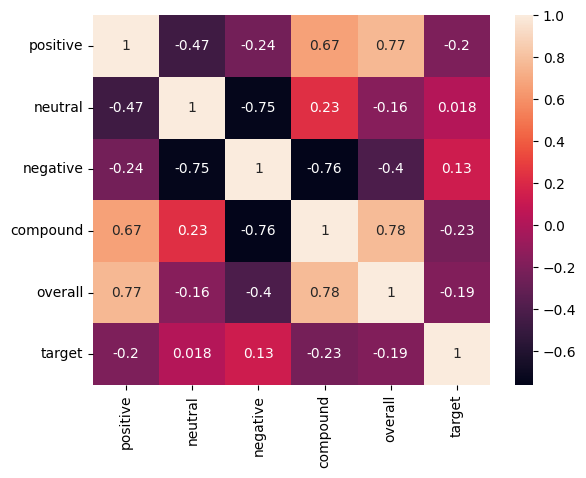

In [30]:
sia = SentimentIntensityAnalyzer()
train['sentiment_score'] = train['transformed_text'].apply(lambda s: sia.polarity_scores(s))
def split_sentiment(s):
    return s['pos'], s['neu'], s['neg'], s['compound']
train[['positive', 'neutral', 'negative', 'compound']] = train['sentiment_score'].apply(lambda s: pd.Series(split_sentiment(s)))
train['overall'] = train['sentiment_score'].apply(lambda d: 1 if d['compound']>0 else 0)
sns.heatmap(data=train[['positive', 'neutral', 'negative', 'compound', 'overall', 'target']].corr(), annot=True);

In [31]:
# Update datasets
train = train.drop(['positive', 'neutral', 'negative', 'overall', 'sentiment_score'], axis=1)

def get_compound_sentiment(df):
    transformed_str = df['transformed_text'].apply(lambda l: ' '.join(l))
    score = transformed_str.apply(lambda s: sia.polarity_scores(s))
    return score.apply(lambda d: d['compound'])
test['compound'] = get_compound_sentiment(test)
train.shape, test.shape

((7613, 20), (3263, 19))

In [32]:
train.head()

,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text,address,length,num_words,avg_word_len,num_stopwords,num_#,num_@,num_puncs,num_urls,#_content,#_score,compound
0,1,[earthquake],,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea...",,69,14,4.071429,6,1,0,1,0,[earthquake],0.901141,0.2732
1,4,[fire],,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]",,38,8,4.000000,0,0,0,1,0,[],0.000000,-0.3400
2,5,[evacuation],,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac...",,133,23,4.869565,11,0,0,3,0,[],0.000000,-0.2960
3,6,[evacuation],,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evacuatio...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev...",,65,11,5.181818,1,1,0,2,0,[wildfires],0.942966,0.0000
4,7,[smoke],,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ...",,88,18,4.000000,7,2,0,2,0,"[Alaska, wildfires]",1.585932,0.0000


**Location**
- Country: There are 6 countries each whose proportion of target is larger than 0.65 or smaller than 0.2
- The length of address: No surprise, it doesn't correlate with target
- Future improvement: We can use this address information to make finer location features

In [33]:
# Extract country name from address
extract_country = lambda df: df['address'].str.extract(r',?([A-Za-z|\s]+)$').astype('str')
train['country'] = extract_country(train)
train.head(70)

,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text,address,length,...,avg_word_len,num_stopwords,num_#,num_@,num_puncs,num_urls,#_content,#_score,compound,country
0,1,[earthquake],,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea...",,69,...,4.071429,6,1,0,1,0,[earthquake],0.901141,0.2732,nan
1,4,[fire],,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]",,38,...,4.000000,0,0,0,1,0,[],0.000000,-0.3400,nan
2,5,[evacuation],,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac...",,133,...,4.869565,11,0,0,3,0,[],0.000000,-0.2960,nan
3,6,[evacuation],,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evacuatio...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev...",,65,...,5.181818,1,1,0,2,0,[wildfires],0.942966,0.0000,nan
4,7,[smoke],,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ...",,88,...,4.000000,7,2,0,2,0,"[Alaska, wildfires]",1.585932,0.0000,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,93,"[fire, ablaze]",Birmingham,@nxwestmidlands huge fire at Wholesale markets...,1.0,@ nxwestmidlands huge fire at wholesale marke...,@nxwestmidlands huge fire at wholesale market ...,"[@, nxwestmidlands, huge, fire, at, wholesale,...","Birmingham, West Midlands Combined Authority, ...",76,...,5.875000,1,0,1,6,1,[],0.000000,-0.0258,United Kingdom
66,95,[ablaze],San Francisco,@ablaze what time does your talk go until? I d...,0.0,@ ablaze what time does your talk go until ? ...,@ablaze what time do your talk go until ? I do...,"[@, ablaze, what, time, does, your, talk, go, ...","San Francisco, California, United States",85,...,2.913043,12,0,1,4,0,[],0.000000,0.0000,United States
67,96,[accident],CLVLND,'I can't have kids cuz I got in a bicycle acci...,0.0,'i cannot have kids because i got in a bicycle...,' I can not have kid cuz I get in a bicycle ac...,"['i, cannot, have, kids, because, i, got, in, ...",,140,...,3.965517,15,0,0,7,0,[],0.000000,-0.4767,nan
68,97,[accident],"Nashville, TN",Accident on I-24 W #NashvilleTraffic. Traffic ...,1.0,accident on i - 24 w # nashvilletraffic . tr...,accident on i-24 w # nashvilletraffic . traffi...,"[accident, on, i, -, 24, w, #, nashvilletraffi...","Nashville-Davidson, Davidson County, Middle Te...",98,...,4.000000,3,1,0,9,1,[NashvilleTraffic],0.714830,-0.4767,United States


In [34]:
# Like hashtag content, get proportions of target=1 with specific countries aside from the count of countries in the column
train['country'] = train['country'].str.strip()
proportions = []
counts = []
countries = list(set(train['country']))
countries = [country for country in countries if country!='nan']
for country in countries:
    tar = 0
    count = 0
    for i in range(len(train)):
        if train['country'].iloc[i]==country:
            count+=1
            if train['target'].iloc[i]:
                tar+=1
    proportions.append(tar/count)
    counts.append(count)

In [35]:
country_prop = pd.DataFrame({'country': countries, 'proportion': proportions, 'count': counts})
top_countries = country_prop[(country_prop['proportion']>0.7) & (country_prop['count']>5)]
bottom_countries = country_prop[(country_prop['proportion']<0.2) & (country_prop['count']>5)]
print(top_countries)
print(bottom_countries)

                country  proportion  count
69              Nigeria    0.732394     71
131  Dominican Republic    1.000000      6
         country  proportion  count
19      Portugal    0.090909     11
30        Taiwan    0.000000     15
36       Morocco    0.142857      7
51        Russia    0.100000     10
110  South Sudan    0.100000     10


In [36]:
# Length of the address
len_address = lambda df: df['address'].str.len()
train['len_address'] = len_address(train)
np.corrcoef(train['len_address'], train['target'])

array([[ 1.       , -0.0093805],
       [-0.0093805,  1.       ]])

In [37]:
# Update datasets
#train = train.drop('len_address', axis=1)

with_good_country = lambda c: 1 if c in list(top_countries['country']) else 0
with_bad_country = lambda c: 1 if c in list(bottom_countries['country']) else 0

test['country'] = extract_country(test)
test['country'] = test['country'].str.strip()

train['with_good_country'] = train['country'].apply(with_good_country)
train['with_bad_country'] = train['country'].apply(with_bad_country)
test['with_good_country'] = test['country'].apply(with_good_country)
test['with_bad_country'] = test['country'].apply(with_bad_country)

train = train.drop('len_address', axis=1)

In [38]:
train.shape, test.shape

((7613, 23), (3263, 22))

# 3. Modeling

**DistilBERT**

In [39]:
# Create the final text
final_text = lambda row: '[CLS] '+row['text']+' [SEP] '+' '.join(row['keyword'])+' [SEP] '+' '.join(row['#_content'])+' [SEP] '+row['country']
train['final_text'] = train.apply(final_text, axis=1)
test['final_text'] = test.apply(final_text, axis=1)

In [40]:
# distilbert
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name, )
distilbert = TFDistilBertModel.from_pretrained(model_name, from_pt=False)

def embedding_generator(text):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = distilbert(inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

texts = train['cleaned_text']
numerical_features = train[['length', 'num_words', 'avg_word_len', 'num_stopwords', 'num_#', 'num_@', 'num_puncs', 'num_urls', '#_score']]
text_embeddings = []
start = time.time()
for text in texts:
    text_embeddings.append(embedding_generator(text))
end = time.time()
end-start

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


1267.6758797168732

In [41]:
text_embeddings = np.array(text_embeddings)
text_embeddings

array([[[-0.00779032,  0.2434276 , -0.19241567, ..., -0.04230931,
          0.5864834 ,  0.00777928]],

       [[-0.50752664,  0.10338587, -0.64529085, ..., -0.25456104,
          0.21263906,  0.3391049 ]],

       [[-0.14549522, -0.16572262,  0.29940528, ..., -0.1827589 ,
          0.02567806,  0.41298488]],

       ...,

       [[-0.42384315, -0.21331161,  0.09302751, ..., -0.18871242,
          0.6688753 ,  0.46447253]],

       [[-0.3773015 , -0.4288999 , -0.14618552, ..., -0.34680358,
          0.184401  ,  0.43837118]],

       [[-0.15121296, -0.4662528 , -0.04027668, ..., -0.22881939,
          0.58398473,  0.13804685]]], dtype=float32)

**Normalize the numerical columns**

In [42]:
def normalize(df, cols):
    for col in cols:
        df[col] = (df[col]-np.mean(df[col]))/np.std(df[col])

normalize(train, ['length', 'num_words', 'avg_word_len', 'num_stopwords', 'num_#', 'num_@', 'num_puncs', 'num_urls', '#_score'])
normalize(test, ['length', 'num_words', 'avg_word_len', 'num_stopwords', 'num_#', 'num_@', 'num_puncs', 'num_urls', '#_score'])

In [43]:
train

,id,keyword,location,text,target,cleaned_text,transformed_text,splitted_text,address,length,...,num_@,num_puncs,num_urls,#_content,#_score,compound,country,with_good_country,with_bad_country,final_text
0,1,[earthquake],,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this # earthquake...,our deed be the reason of this # earthquake ma...,"[our, deeds, are, the, reason, of, this, #, ea...",,-0.948439,...,-0.503308,-1.267124,-0.934080,[earthquake],1.148469,0.2732,nan,0,0,[CLS] Our Deeds are the Reason of this #earthq...
1,4,[fire],,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask . canada,forest fire near la ronge sask . canada,"[forest, fire, near, la, ronge, sask, ., canada]",,-1.866166,...,-0.503308,-1.267124,-0.934080,[],-0.345020,-0.3400,nan,0,0,[CLS] Forest fire near La Ronge Sask. Canada [...
2,5,[evacuation],,All residents asked to 'shelter in place' are ...,1.0,all residents asked to 'shelter in place' are ...,all resident ask to ' shelter in place ' be be...,"[all, residents, asked, to, 'shelter, in, plac...",,0.946223,...,-0.503308,-0.833139,-0.934080,[],-0.345020,-0.2960,nan,0,0,[CLS] All residents asked to 'shelter in place...
3,6,[evacuation],,"13,000 people receive #wildfires evacuation or...",1.0,"13 , 000 people receive # wildfires evacuatio...","13,000 people receive # wildfire evacuation or...","[13, ,, 000, people, receive, #, wildfires, ev...",,-1.066856,...,-0.503308,-1.050132,-0.934080,[wildfires],1.217788,0.0000,nan,0,0,"[CLS] 13,000 people receive #wildfires evacuat..."
4,7,[smoke],,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby # alaska a...,just get send this photo from ruby # alaska as...,"[just, got, sent, this, photo, from, ruby, #, ...",,-0.385962,...,-0.503308,-1.050132,-0.934080,"[Alaska, wildfires]",2.283396,0.0000,nan,0,0,[CLS] Just got sent this photo from Ruby #Alas...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,[collapse],,Two giant cranes holding a bridge collapse int...,1.0,two giant cranes holding a bridge collapse int...,two giant crane hold a bridge collapse into ne...,"[two, giant, cranes, holding, a, bridge, colla...",,-0.533982,...,-0.503308,-0.399154,0.572201,[],-0.345020,-0.4939,nan,0,0,[CLS] Two giant cranes holding a bridge collap...
7609,10870,[],,@aria_ahrary @TheTawniest The out of control w...,1.0,@ aria _ ahrary @ thetawniest the out of con...,@aria_ahrary @thetawniest the out of control w...,"[@, aria, _, ahrary, @, thetawniest, the, out,...",,0.709390,...,2.274280,-0.399154,-0.934080,[],-0.345020,-0.7346,nan,0,0,[CLS] @aria_ahrary @TheTawniest The out of con...
7610,10871,[volcano],,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1.0,m1 . 94 [ 01 : 04 utc ] ? 5km s of volcano h...,m1.94 [ 01:04 utc]?5 km s of volcano hawaii . ...,"[m1, ., 94, [, 01, :, 04, utc, ], ?, 5km, s, o...",,-1.066856,...,-0.503308,0.902800,0.572201,[],-0.345020,0.0000,nan,0,0,[CLS] M1.94 [01:04 UTC]?5km S of Volcano Hawai...
7611,10872,"[police, injuries, collided]",,Police investigating after an e-bike collided ...,1.0,police investigating after an e - bike collide...,police investigate after an e - bike collide w...,"[police, investigating, after, an, e, -, bike,...",,1.064639,...,-0.503308,-0.399154,-0.934080,[],-0.345020,-0.8591,nan,0,0,[CLS] Police investigating after an e-bike col...


**Confusion Matrix Function**

In [44]:
def confusionMatrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(data=cm, index=['0', '1'], columns=['0', '1'])
    tn, fp, fn, tp = cm.ravel()
    f1 = tp / (tp+((fn+fp)/2))
    
    sns.heatmap(cm_df, annot=True, cbar=False, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix with f1_score: {f1}')
    plt.show();

# a. Custom Model

In [45]:
random.seed(42)
val_ind = random.sample(range(0, 7613), 1522)
train_ind = [i for i in range(7613) if i not in val_ind]
train_text_embeddings = text_embeddings[train_ind]
val_text_embeddings = text_embeddings[val_ind]
train_numerical_features = numerical_features.iloc[train_ind]
val_numerical_features = numerical_features.iloc[val_ind]

In [46]:
text_input = Input(shape=(train_text_embeddings.shape[-1],), name='text_input')
numerical_input = Input(shape=(train_numerical_features.shape[1],), name='numerical_input')
numerical_dense = Dense(128, activation='relu')(numerical_input)  # apply dense layer for the sake of compatibility
custom_together = Concatenate()([text_input, numerical_dense])
custom_output = Dense(1, activation='sigmoid')(Dense(64, activation='relu')(custom_together))

custom_model = Model(inputs=[text_input, numerical_input], outputs=custom_output)
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'auc'])
custom_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,280 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 896)       │          0 │ text_input[0][0], │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     57,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,753 (229.50 KB)

 Trainable params: 58,753 (229.50 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Setting callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6796 - auc: 0.7147 - loss: 0.6913 - val_accuracy: 0.7549 - val_auc: 0.8552 - val_loss: 0.5687
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7936 - auc: 0.8555 - loss: 0.4593 - val_accuracy: 0.7602 - val_auc: 0.8642 - val_loss: 0.4819
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8085 - auc: 0.8722 - loss: 0.4293 - val_accuracy: 0.7989 - val_auc: 0.8727 - val_loss: 0.4339
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8069 - auc: 0.8714 - loss: 0.4318 - val_accuracy: 0.7891 - val_auc: 0.8706 - val_loss: 0.4958
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8182 - auc: 0.8784 - loss: 0.4172 - val_accuracy: 0.8009 - val_auc: 0.8748 - val_loss: 0.4288
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8254 - auc: 0.8895 - loss: 0.3990 - val_accuracy: 0.8035 - val_auc: 0.8762 - val_loss: 0.4222
Epoch 7/100
191/191 ━━━━━━━━━━━━━

<Axes: >

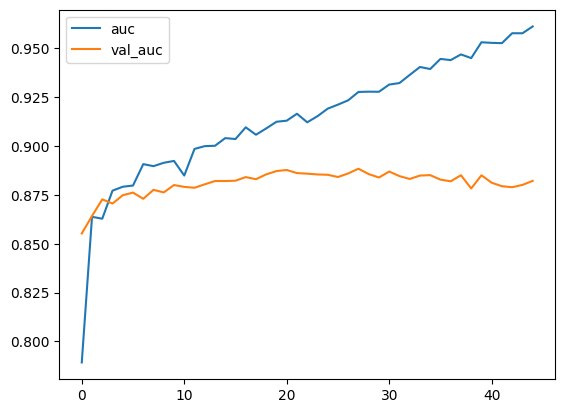

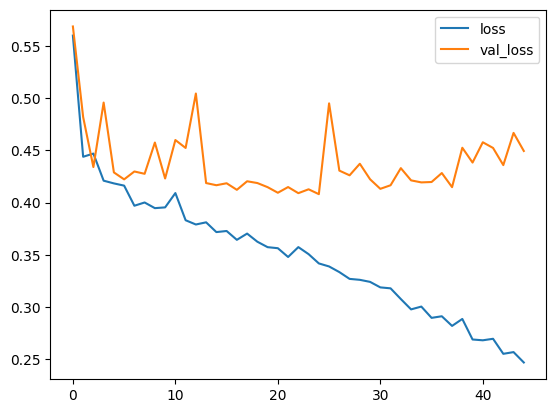

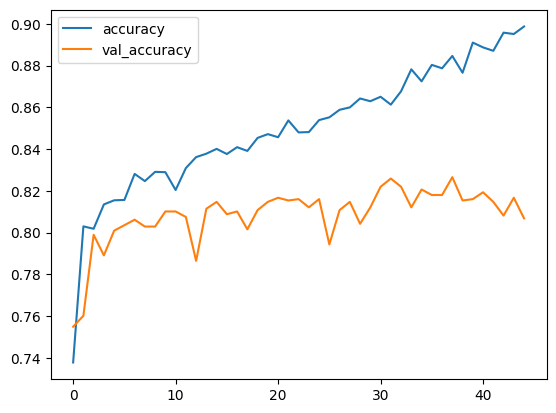

In [48]:
text_train = np.stack(train_text_embeddings.astype(np.float32)).squeeze(axis=1)
text_val = np.stack(val_text_embeddings.astype(np.float32)).squeeze(axis=1)
numerical_train = np.asarray(train_numerical_features).astype(np.float32)
numerical_val = np.asarray(val_numerical_features).astype(np.float32)
custom_y_train = np.asarray(train['target'][train_ind]).astype(np.float32)
custom_y_val = np.asarray(train['target'][val_ind]).astype(np.float32)

history = custom_model.fit([text_train, numerical_train],
                           custom_y_train,
                           epochs=100,
                           batch_size=32,
                           validation_data=([text_val, numerical_val], custom_y_val),
                           callbacks=[early_stopping]
                          )
history_df = pd.DataFrame(data=history.history)
history_df.loc[:, ['auc', 'val_auc']].plot()
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [49]:
# At epoch=30, val-loss starts raising which is a characteristic of overfit
text_input = Input(shape=(train_text_embeddings.shape[-1],), name='text_input')
numerical_input = Input(shape=(train_numerical_features.shape[1],), name='numerical_input')
numerical_dense = Dense(128, activation='relu')(numerical_input)  # apply dense layer for the sake of compatibility
custom_together = Concatenate()([text_input, numerical_dense])
custom_output = Dense(1, activation='sigmoid')(Dense(64, activation='relu')(custom_together))

custom_model = Model(inputs=[text_input, numerical_input], outputs=custom_output)
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'auc'])
custom_model.fit([text_train, numerical_train], custom_y_train, epochs=30, batch_size=32)

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6897 - auc: 0.7157 - loss: 0.7345
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7918 - auc: 0.8554 - loss: 0.4619
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8145 - auc: 0.8794 - loss: 0.4195
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - auc: 0.8836 - loss: 0.4160
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8252 - auc: 0.8838 - loss: 0.4073
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8210 - auc: 0.8820 - loss: 0.4091
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8268 - auc: 0.8934 - loss: 0.3934
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8223 - auc: 0.8933 - loss: 0.3942
Epoch 9/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8343 - auc: 0.8995 - loss: 0.3819
Epoch 10/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8329 - auc: 0.8943 - loss: 0.3848

# b. Scikit-learn Models

In [50]:
cols = ['distilbert_'+str(i) for i in range(len(text_embeddings[0][0]))]
X = pd.concat([pd.DataFrame(np.stack(text_embeddings).squeeze(axis=1), columns=cols), numerical_features], axis=1)
y = train['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

**Hyperparameter tuning**

In [51]:
# Create models
lr_l1 = LogisticRegression(penalty="l1", max_iter=100)
lr_l2 = LogisticRegression(penalty="l2", max_iter=100)
knn = KNeighborsClassifier()
rfc = RandomForestClassifier(random_state=42)
models = [lr_l1, lr_l2, knn, rfc]
model_names = ['lr_l1', 'lr_l2', 'knn', 'rfc']

In [52]:
# Create a dictionary of hyperparameters for every model
lr_l1_param = {'C': [0.1, 1, 10],
                'solver': ['liblinear', 'saga']
               }
lr_l2_param = {'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
               }
knn_param = {'n_neighbors': [5, 9, 13]}
rfc_param = {'n_estimators': [10, 50, 100]}
params = [lr_l1_param, lr_l2_param, knn_param, rfc_param]

In [53]:
# Finding the best parameter set for each model
'''
def best_param_finder(model, params, model_name):
    classifier = GridSearchCV(estimator=model, param_grid=params, cv=5)
    classifier.fit(X_train, y_train)
    return {'Model': model_name, 'Best Parameter': classifier.best_params_, 'Score': classifier.best_score_}

results = []
for i in range(len(models)):
    results.append(best_param_finder(models[i], params[i], model_names[i]))
    print(model_names[i], 'Done.')
results_grid = pd.DataFrame(data=results, columns=['Model', 'Best Parameter', 'Score'])
results_grid
'''

"\ndef best_param_finder(model, params, model_name):\n    classifier = GridSearchCV(estimator=model, param_grid=params, cv=5)\n    classifier.fit(X_train, y_train)\n    return {'Model': model_name, 'Best Parameter': classifier.best_params_, 'Score': classifier.best_score_}\n\nresults = []\nfor i in range(len(models)):\n    results.append(best_param_finder(models[i], params[i], model_names[i]))\n    print(model_names[i], 'Done.')\nresults_grid = pd.DataFrame(data=results, columns=['Model', 'Best Parameter', 'Score'])\nresults_grid\n"

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


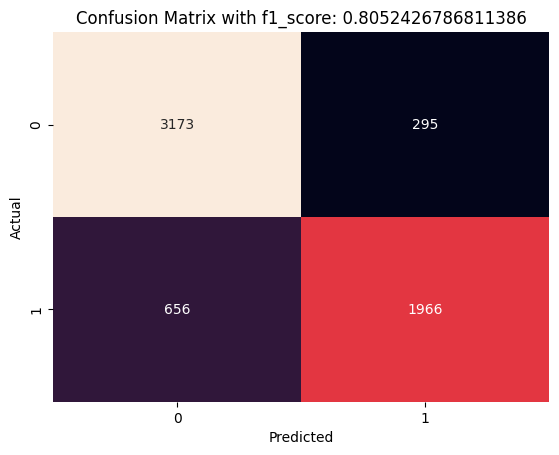

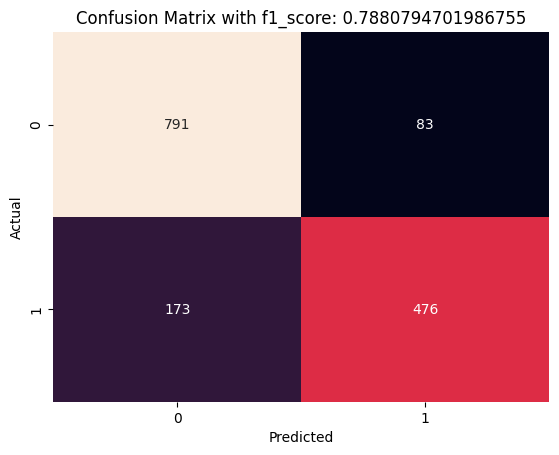

In [54]:
# confusion matrix for the best score model
sklearn_model = LogisticRegression(penalty="l1", max_iter=1000, C=1.0, solver='saga')
sklearn_model.fit(X_train, y_train)
sklearn_train_y_pred = sklearn_model.predict(X_train)
sklearn_val_y_pred = sklearn_model.predict(X_val)
confusionMatrix(y_train, sklearn_train_y_pred)
confusionMatrix(y_val, sklearn_val_y_pred)

# 4. Model Selection

In [55]:
test.head()

,id,keyword,location,text,cleaned_text,transformed_text,splitted_text,address,length,num_words,...,num_@,num_puncs,num_urls,#_content,#_score,compound,country,with_good_country,with_bad_country,final_text
0,0,[crash],,Just happened a terrible car crash,just happened a terrible car crash,just happen a terrible car crash,"[just, happened, a, terrible, car, crash]",,-2.005131,-1.586987,...,-0.517091,-1.549461,-0.949413,[],-0.268245,0.0,nan,0,0,[CLS] Just happened a terrible car crash [SEP]...
1,2,[earthquake],,"Heard about #earthquake is different cities, s...",heard about # earthquake is different cities ...,"hear about # earthquake be different city , st...","[heard, about, #, earthquake, is, different, c...",,-1.121919,-0.787532,...,-0.517091,-0.880692,-0.949413,[earthquake],1.977167,0.0,nan,0,0,[CLS] Heard about #earthquake is different cit...
2,3,[fire],,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond , geese a...","there be a forest fire at spot pond , geese be...","[there, is, a, forest, fire, at, spot, pond, ,...",,-0.179827,0.411651,...,-0.517091,-1.103615,-0.949413,[],-0.268245,0.0,nan,0,0,"[CLS] there is a forest fire at spot pond, gee..."
3,9,[apocalypse],,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting . # spokane # wildfires,apocalypse lighting . # spokane # wildfire,"[apocalypse, lighting, ., #, spokane, #, wildf...",,-1.828489,-1.453745,...,-0.517091,-0.880692,-0.949413,"[Spokane, wildfires]",2.081385,0.0,nan,0,0,[CLS] Apocalypse lighting. #Spokane #wildfires...
4,11,[typhoon],,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kill 28 in china and taiwan,"[typhoon, soudelor, kills, 28, in, china, and,...",,-1.681287,-1.320502,...,-0.517091,-1.549461,-0.949413,[],-0.268245,0.0,nan,0,0,[CLS] Typhoon Soudelor kills 28 in China and T...


In [56]:
test_texts = test['cleaned_text']
test_numerical_features = test[['length', 'num_words', 'avg_word_len', 'num_stopwords', 'num_#', 'num_@', 'num_puncs', 'num_urls', '#_score']]
test_text_embeddings = []
start = time.time()
for text in test_texts:
    test_text_embeddings.append(embedding_generator(text))
end = time.time()
end-start

545.6652143001556

In [57]:
test_text_embeddings = np.array(test_text_embeddings)
len(test_text_embeddings)

3263

**Custom Model**

In [58]:
test_text = np.stack(test_text_embeddings.astype(np.float32)).squeeze(axis=1)
test_numerical = np.asarray(test_numerical_features).astype(np.float32)
#test_predictions = (custom_model.predict([test_text, test_numerical])>0.5).astype(int)
#test_predictions

**Sklearn Model (Logistic Regression with L1 Peneralization)**

In [59]:
train_predictions, validation_predictions = sklearn_model.predict(X_train), sklearn_model.predict(X_val)
training_accuracy = np.mean(train_predictions==y_train)
validation_accuracy = np.mean(validation_predictions==y_val)
training_accuracy, validation_accuracy

(0.8438423645320197, 0.8319107025607354)

In [60]:
X_test = pd.concat([pd.DataFrame(np.stack(test_text_embeddings).squeeze(axis=1), columns=cols), test_numerical_features], axis=1)
test_predictions = sklearn_model.predict(X_test)
test_predictions = [int(x) for x in test_predictions]

# 5. Submission

In [61]:
#test_predictions.shape

In [62]:
# Custom model gets the predictions in a nested list so is being converted here
#test_predictions = itertools.chain(*test_predictions)

In [63]:
submission = pd.DataFrame({'id': test.id, 'target': list(test_predictions)})
submission.to_csv('submission.csv', index=False)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
